In [ ]:
# !pip install git+https://github.com/petercorke/robotics-toolbox-python


In [35]:
from math import pi
import math
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb

In [4]:
robot = rtb.models.DH.KR5()
print(robot)


DHRobot: KR5 (by KUKA), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌─────┬────────┬──────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │  aⱼ  │   ⍺ⱼ   │   q⁻    │   q⁺   │
├─────┼────────┼──────┼────────┼─────────┼────────┤
│  q1 │    0.4 │ 0.18 │ -90.0° │ -155.0° │ 155.0° │
│  q2 │      0 │  0.6 │   0.0° │ -180.0° │  65.0° │
│  q3 │      0 │ 0.12 │  90.0° │  -15.0° │ 158.0° │
│  q4 │  -0.62 │    0 │ -90.0° │ -350.0° │ 350.0° │
│  q5 │      0 │    0 │  90.0° │ -130.0° │ 130.0° │
│  q6 │ -0.115 │    0 │ 180.0° │ -350.0° │ 350.0° │
└─────┴────────┴──────┴────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘

┌──────┬──────┬──────┬──────┬──────┬──────┬──────┐
│ name │ q0   │ q1   │ q2   │ q3   │ q4   │ q5   │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│   qr │  45° │  60° │  45° │  30° │  45° │  30° │
│   qz │  0°  │  0°  │  0°  │  0°  │  0°  │  0°  │
│  qk1 │  45° │  60° │  45° │  30° │  45° │  30° │
│  qk2 │  45° │  60° │  30° │  60° │  45° │  30° │
│  qk3 │  30° │  60

Общий вес робота Kuka KR5, согласно документации, равен 127 килограмм. На основе габаритов робота сделаем предположение о распределении общей массы по каждому из звеньев

In [5]:
robot.links[0].m = 40;
robot.links[1].m = 30;
robot.links[2].m = 30;
robot.links[3].m = 14;
robot.links[4].m = 8;
robot.links[5].m = 5;

Зададим центры масс для каждого звена в геометрическом центре модели
этого звена

In [13]:
robot.links[0].r = [0, 0, robot.links[0].a/2];
robot.links[1].r = [0, robot.links[1].a/2, 0];
robot.links[2].r = [0, robot.links[2].a/2, 0];
robot.links[3].r = [0, -robot.links[3].a/2, 0];
robot.links[4].r = [0, robot.links[4].a/2, 0];
robot.links[5].r = [0, 0, robot.links[5].a/2];


Выбираем тензоры инерции относительно центров масс. Предположим, что каждое звено имеет цилиндрическую форму. 

In [34]:
r = 0.2; # Радиус цилиндрического звена
robot.links[0].I = np.array([[robot.links[0].m * (3 * r**2 + robot.links[0].a**2)  / 12, 0, 0],
                    [0, robot.links[0].m * (3 * r**2 +robot.links[0].a**2)  / 12,  0],
                    [0, 0, robot.links[0].m * robot.links[0].a**2 /2]])

robot.links[1].I = np.array([[robot.links[1].m * robot.links[1].a**2 / 12, 0, 0],
                    [0, 0, 0],
                    [0, 0, robot.links[1].m * robot.links[1].a**2 /12]])

robot.links[2].I = np.array([[robot.links[2].m * robot.links[2].a**2 / 12, 0, 0],
                    [0, 0, 0],
                    [0, 0, robot.links[2].m * robot.links[2].a**2 /12]])


robot.links[3].I = np.array([[robot.links[3].m * (3 * r**2 + robot.links[3].a**2)  / 12, 0, 0],
                    [0, robot.links[3].m * (3 * r**2 +robot.links[3].a**2)  / 12,  0],
                    [0, 0, robot.links[3].m * robot.links[3].a**2 /2]])

robot.links[4].I = np.array([[robot.links[4].m * robot.links[4].a**2 / 12, 0, 0],
                    [0, 0, 0],
                    [0, 0, robot.links[4].m * robot.links[4].a**2 /12]])

robot.links[5].I = np.array([[robot.links[5].m * (3 * r**2 + robot.links[5].a**2)  / 12, 0, 0],
                    [0, robot.links[5].m * (3 * r**2 + robot.links[5].a**2)  / 12,  0],
                    [0, 0, robot.links[5].m * robot.links[5].a**2 / 2]])

Выставим ограничения по обобщённым координатам:

In [38]:
robot.links[0].qlim = np.array([math.radians(-155), math.radians(155)])
robot.links[1].qlim = np.array([math.radians(-180), math.radians(65)])
robot.links[2].qlim = np.array([math.radians(-15), math.radians(158)])
robot.links[3].qlim = np.array([math.radians(-350), math.radians(350)])
robot.links[4].qlim = np.array([math.radians(-130), math.radians(130)])
robot.links[5].qlim = np.array([math.radians(-350), math.radians(350)])


Установим моменты инерции моторов:

In [39]:
robot.links[0].Jm = 0.05
robot.links[1].Jm = 0.05
robot.links[2].Jm = 0.05
robot.links[3].Jm = 0.05
robot.links[4].Jm = 0.05
robot.links[5].Jm = 0.05

Передаточные числа редукторов:

In [40]:
robot.links[0].G = 1
robot.links[1].G = 1
robot.links[2].G = 1
robot.links[3].G = 1
robot.links[4].G = 1
robot.links[5].G = 1

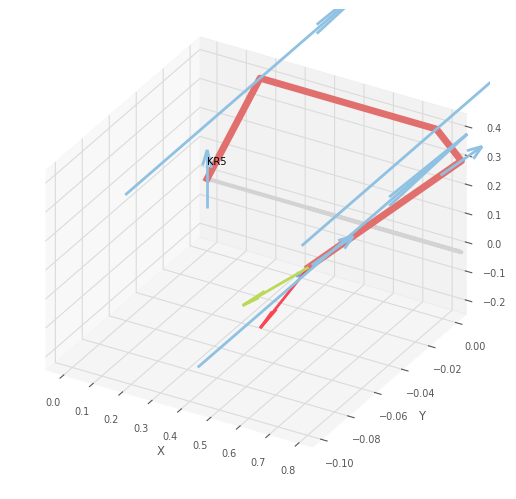

PyPlot3D backend, t = 0.05, scene:
  KR5

<Figure size 640x480 with 0 Axes>

In [43]:
q_init = np.array([0, 0, pi/4, 0, 0, -pi/4])
q_final = np.array([pi/2, pi/4, 0, -pi/2, 0, 0])
robot.plot(q_init,backend='pyplot')